### Loading Libraries

In [2]:
import os
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from io import BytesIO
import numpy as np
import anndata
import joblib
import pickle
from matplotlib import pyplot as plt
import scipy as sp
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn import metrics
import scanpy as sc
import sklearn.cluster as cluster
import umap
from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image as image_fun
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from adjustText import adjust_text

import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
from geopandas import GeoDataFrame
from libpysal.weights import Queen
from esda.moran import (Moran, Moran_BV, Moran_Local, Moran_Local_BV)
from splot.esda import lisa_cluster

from anndata import AnnData
from typing import Optional, Union
from matplotlib.backends.backend_agg import FigureCanvasAgg
from skimage.filters import threshold_otsu, threshold_multiotsu
from sklearn.metrics import jaccard_score

### ResNet50 and Logistic Regression

In [5]:
#Computing ResNet50 features
def ResNet50_features(pre_model, anndata):
    resnet_features = []
    for imagePath in anndata.obs["tile_path"]:
        image = plt.imread(imagePath).astype('float32')
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        resnet_features.append(pre_model.predict(image, batch_size=1))
        
    #Shape of resnet50 features is coming out as (no. of tiles, 1, no. of resnet features)
    resnet_features = np.asarray(resnet_features)
    anndata.obsm["resnet50_features"] = resnet_features.reshape(resnet_features.shape[0],resnet_features.shape[2])    
    
#Training Pre-Processing
def classification_preprocessing(anndata):
    gene_exp = anndata.to_df() 
    gene_exp['library_id'] = anndata.obs['library_id']
    gene_exp_zscore = gene_exp.groupby('library_id')[list(gene_exp.iloc[:,:-1].columns)].apply(lambda x: (x-x.mean())/(x.std()))
    anndata.X = pd.DataFrame(gene_exp_zscore.apply(lambda x: [0 if y <= 0 else 1 for y in x]),
                                                       columns = anndata.to_df().columns, index = anndata.obs.index)


#Logistic Regression Classifier
def LR_model(train_adata, iteration=10000, penalty_option="elasticnet", regularization_strength=0.1, optimization="saga", l1_l2_ratio=0.5):
    model_c = LogisticRegression(max_iter=iteration, penalty=penalty_option, C=regularization_strength,solver=optimization,l1_ratio=l1_l2_ratio)
    clf_resnet = MultiOutputClassifier(model_c).fit(train_adata.obsm["resnet50_features"], train_adata.obsm["true_gene_expression"])
    joblib.dump(clf_resnet, Path+'pickle/LRmodel.pkl')

### Performance Evaluation

In [6]:
def performance_metrics(test_adata, gene_list):
    AUROC = []; F1 = []; Precision = []; Recall = []
    for i in set(test_adata.obs["library_id"]):
        anndata_adata = test_adata[test_adata.obs["library_id"]==i]
        for j in gene_list:
            score_auroc = roc_auc_score(anndata_adata.obsm["predicted_gene_expression"][j],anndata_adata.obsm["true_gene_expression"][j])
            AUROC.append(score_auroc)

            score_f1 =  f1_score(anndata_adata.obsm["predicted_gene_expression"][j],anndata_adata.obsm["true_gene_expression"][j])
            F1.append(score_f1)

            score_precision =  precision_score(anndata_adata.obsm["predicted_gene_expression"][j],anndata_adata.obsm["true_gene_expression"][j])
            Precision.append(score_precision)

            score_recall =  recall_score(anndata_adata.obsm["predicted_gene_expression"][j],anndata_adata.obsm["true_gene_expression"][j])
            Recall.append(score_recall)

    Performance_metrics = pd.concat([pd.DataFrame(AUROC), pd.DataFrame(F1), pd.DataFrame(Precision), pd.DataFrame(Recall)])
    Performance_metrics['Patient'] = list(np.repeat(list(set(test_adata.obs["library_id"])),len(gene_list)))*4
    Performance_metrics['Genes'] = gene_list*len(set(Performance_metrics['Patient']))*4
    Performance_metrics['Metrics'] = ['AUROC']*len(AUROC)+['F1']*len(F1)+['Precision']*len(Precision)+['Recall']*len(Recall)

    sns.set(font_scale = 2, style="whitegrid",)
    plt.figure(figsize=(22.50,12.50))
    plt.ylim(-0.1, 1.10)
    im = sns.boxplot(x="Patient", y=0, hue="Metrics", data=Performance_metrics,linewidth=3.5,width=0.6)
    im.set_xticklabels(im.get_xticklabels(),rotation = 30)
    plt.legend(loc="lower right", frameon=True, fontsize=20)
    im.axhline(0.5, linewidth=2, color='r')

    sns.set(font_scale = 2, style="whitegrid",)
    plt.figure(figsize=(22.50,12.50))
    plt.ylim(-0.1, 1.10)
    im2 = sns.boxplot(x="Genes", y=0, hue="Metrics", data=Performance_metrics,linewidth=3.5,width=0.6)
    im2.set_xticklabels(im2.get_xticklabels(),rotation = 30)
    plt.legend(loc="lower right", frameon=True, fontsize=20)
    im2.axhline(0.5, linewidth=2, color='r')

    return im.figure.savefig(Path+'Classification_boxplot_cancer_immune_controls_top100.png'), im2.figure.savefig(Path+'Classification_boxplot_cancer_immune_controls_genes_top100.png')

def plotting_genes(library_id):
    adata = test_adata[test_adata.obs["library_id"].isin([library_id])]
    arr = clf_resnet.predict_proba(adata.obsm["resnet50_features"])
    second_dimension_values = [arr[:, 1] for arr in arr]
    df = pd.DataFrame({f'Column_{i+1}': array for i, array in enumerate(second_dimension_values)})
    df.columns = gene_list
    df.index = adata.obs.index
    df["imagerow"] = adata.obs["imagerow"]
    df["imagecol"] = adata.obs["imagecol"]
    return df, adata

def normalize_column(column):
    return (column - column.min()) / (column.max() - column.min())

def zscore_column(column):
    return zscore(column)

def predicted_proba(adata):
    arr = clf_resnet.predict_proba(adata.obsm["resnet50_features"])
    second_dimension_values = [arr[:, 1] for arr in arr]
    df = pd.DataFrame({f'Column_{i+1}': array for i, array in enumerate(second_dimension_values)})
    df.columns = gene_list
    df.index = adata.obs.index
    adata.obsm["continuous_predicted_gene_expression"] = df
        
def gene_correlation_proba(adata, final_moran, sample,image_res="lowres"):
    moran_list = list()
    moran_bv_list = list()
    scale = adata.uns["spatial"][sample]["scalefactors"]["tissue_" + image_res + "_scalef"]
    image_coor = adata.obsm["spatial"] * scale
    adata.obs["imagecol"] = image_coor[:, 0]
    adata.obs["imagerow"] = image_coor[:, 1]
    adata.obsm["gpd"] = gpd.GeoDataFrame(adata.obs, geometry=gpd.points_from_xy(
        adata.obs.imagecol,
        adata.obs.imagerow))
    for i, gene1 in enumerate(gene_list1):
        print("Computing " + gene1)
        x = adata.to_df().apply(normalize_column)[gene1].values.astype(np.float64)
        y = adata.obsm["continuous_predicted_gene_expression"][gene1].values.astype(np.float64)
        w = Queen.from_dataframe(adata.obsm["gpd"])
        tissue_image = adata.uns["spatial"][list(adata.uns["spatial"].keys())[0]]["images"][image_res]
        moran = Moran(y, w)
        moran_bv = Moran_BV(y, x, w)
        moran_list.append(moran.I)
        moran_bv_list.append(moran_bv.I)
        moran_loc = Moran_Local(y, w)
        moran_loc_bv = Moran_Local_BV(y, x, w)
        moran_loc_bvdf = pd.concat([pd.DataFrame(moran_loc_bv.Is),pd.DataFrame(moran_loc_bv.p_z_sim),pd.DataFrame(moran_loc_bv.q)],axis=1)
        moran_loc_bvdf.columns = ["Is","p_z_sim","q"]
        moran_loc_bvdf["pathway"]=gene1
        final_moran = pd.concat([final_moran,moran_loc_bvdf],axis=0)
    return(adata,moran_list,moran_bv_list,final_moran)

def gene_correlation_zsproba(adata, final_moran, sample,image_res="lowres"):
    moran_list = list()
    moran_bv_list = list()
    scale = adata.uns["spatial"][sample]["scalefactors"]["tissue_" + image_res + "_scalef"]
    image_coor = adata.obsm["spatial"] * scale
    adata.obs["imagecol"] = image_coor[:, 0]
    adata.obs["imagerow"] = image_coor[:, 1]
    adata.obsm["gpd"] = gpd.GeoDataFrame(adata.obs, geometry=gpd.points_from_xy(
        adata.obs.imagecol,
        adata.obs.imagerow))
    for i, gene1 in enumerate(gene_list1):
        print("Computing " + gene1)
        x = adata.to_df().apply(zscore_column)[gene1].values.astype(np.float64)
        y = adata.obsm["continuous_predicted_gene_expression"].apply(zscore_column)[gene1].values.astype(np.float64)
        w = Queen.from_dataframe(adata.obsm["gpd"])
        tissue_image = adata.uns["spatial"][list(adata.uns["spatial"].keys())[0]]["images"][image_res]
        moran = Moran(y, w)
        moran_bv = Moran_BV(y, x, w)
        moran_list.append(moran.I)
        moran_bv_list.append(moran_bv.I)
        moran_loc = Moran_Local(y, w)
        moran_loc_bv = Moran_Local_BV(y, x, w)
        moran_loc_bvdf = pd.concat([pd.DataFrame(moran_loc_bv.Is),pd.DataFrame(moran_loc_bv.p_z_sim),pd.DataFrame(moran_loc_bv.q)],axis=1)
        moran_loc_bvdf.columns = ["Is","p_z_sim","q"]
        moran_loc_bvdf["pathway"]=gene1
        final_moran = pd.concat([final_moran,moran_loc_bvdf],axis=0)
    return(adata,moran_list,moran_bv_list,final_moran)

def gene_correlation_prediction(adata, final_moran, sample,image_res="lowres"):
    moran_list = list()
    moran_bv_list = list()
    scale = adata.uns["spatial"][sample]["scalefactors"]["tissue_" + image_res + "_scalef"]
    image_coor = adata.obsm["spatial"] * scale
    adata.obs["imagecol"] = image_coor[:, 0]
    adata.obs["imagerow"] = image_coor[:, 1]
    adata.obsm["gpd"] = gpd.GeoDataFrame(adata.obs, geometry=gpd.points_from_xy(
        adata.obs.imagecol,
        adata.obs.imagerow))
    for i, gene1 in enumerate(gene_list1):
        print("Computing " + gene1)
        x = adata.obsm["true_gene_expression"][gene1].values.astype(np.float64)
        y = adata.obsm["predicted_gene_expression"][gene1].values.astype(np.float64)
        w = Queen.from_dataframe(adata.obsm["gpd"])
        tissue_image = adata.uns["spatial"][list(adata.uns["spatial"].keys())[0]]["images"][image_res]
        moran = Moran(y, w)
        moran_bv = Moran_BV(y, x, w)
        moran_list.append(moran.I)
        moran_bv_list.append(moran_bv.I)
        moran_loc = Moran_Local(y, w)
        moran_loc_bv = Moran_Local_BV(y, x, w)
        moran_loc_bvdf = pd.concat([pd.DataFrame(moran_loc_bv.Is),pd.DataFrame(moran_loc_bv.p_z_sim),pd.DataFrame(moran_loc_bv.q)],axis=1)
        moran_loc_bvdf.columns = ["Is","p_z_sim","q"]
        moran_loc_bvdf["pathway"]=gene1
        final_moran = pd.concat([final_moran,moran_loc_bvdf],axis=0)
    return(adata,moran_list,moran_bv_list,final_moran)

In [7]:
#Boxplot of Performance Metrics
def performance_metrics_exceptional(Path, gene_exp_binary_all_true, performance_metrics_all_predictions, gene_list):
    AUROC_genes = []; F1_genes = []; Precision_genes = []; Recall_genes = [];
    for dataset in range(len(gene_exp_binary_all_true)):
        for gene in range(len(gene_list)):
            try:
                score =  roc_auc_score(performance_metrics_all_predictions[dataset].iloc[:,gene],gene_exp_binary_all_true[dataset].iloc[:,gene])
                AUROC_genes.append(score)
            except:
                AUROC_genes.append(score)

    for dataset in range(len(gene_exp_binary_all_true)):
        for gene in range(len(gene_list)):
            try:
                score =  f1_score(performance_metrics_all_predictions[dataset].iloc[:,gene],gene_exp_binary_all_true[dataset].iloc[:,gene])
                F1_genes.append(score)
            except:
                F1_genes.append(score)

    for dataset in range(len(gene_exp_binary_all_true)):
        for gene in range(len(gene_list)):
            try:
                score =  precision_score(performance_metrics_all_predictions[dataset].iloc[:,gene],gene_exp_binary_all_true[dataset].iloc[:,gene])
                Precision_genes.append(score)
            except:
                Precision_genes.append(score)

    for dataset in range(len(gene_exp_binary_all_true)):
        for gene in range(len(gene_list)):
            try:
                score =  recall_score(performance_metrics_all_predictions[dataset].iloc[:,gene],gene_exp_binary_all_true[dataset].iloc[:,gene])
                Recall_genes.append(score)
            except:
                Recall_genes.append(score)

    AUROC_genes = pd.DataFrame(AUROC_genes); F1_genes = pd.DataFrame(F1_genes); Precision_genes = pd.DataFrame(Precision_genes); Recall_genes = pd.DataFrame(Recall_genes)
    Performance_metrics = pd.concat([AUROC_genes,F1_genes,Precision_genes,Recall_genes])
    Performance_metrics['patient'] = list(np.repeat(pd.concat(gene_exp_binary_all_true).loc[~(pd.concat(gene_exp_binary_all_true)['dataset'].isin(train_data_library_id))].drop_duplicates('dataset', keep='first')['dataset'].to_list(),len(gene_list)))*4
    Performance_metrics['genes'] = gene_list*len(set(Performance_metrics['patient']))*4
    Performance_metrics['measure'] = ['AUROC']*len(AUROC_genes)+['F1']*len(F1_genes)+['Precision']*len(Precision_genes)+['Recall']*len(Recall_genes)

    plt.figure(figsize=(19.20,10.80))
    im = sns.boxplot(x="patient", y=0, hue="measure", data=Performance_metrics,linewidth=4)
    im.axhline(0.5, linewidth=2, color='r')
    return im.figure.savefig(Path+'Classification_boxplot.png')

### Cancer vs Non-Cancer Spot Clustering

In [8]:
# Clustering followed by Classification
def clustering(train_adata):
    clustering = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
    model_c = LogisticRegression(max_iter=10000,penalty='elasticnet',C=0.1,solver='saga',l1_ratio=0.5)
    clf_can_v_non_can = model_c.fit(train_adata.obsm["true_gene_expression"],clustering.fit_predict(train_adata.obsm["true_gene_expression"]))
    joblib.dump(clf_can_v_non_can, Path+'pickle/resnet_block1_log_scaled_relu_clustering_logistic.pkl')

#### Cancer genes

In [7]:
# Path = "/scratch/project/stseq/Onkar/STimage_v1/"
# with open(Path+'Outputs/pickle/pkl/top_100gene.pkl', 'rb') as f:
#     gene_list = list(pickle.load(f)) 
    
# DisGenet =  pd.read_csv("/scratch/project/stseq/Onkar/STimage_v1/Outputs/pickle/csv/DisGeNET_table.txt",sep="\t")
# list(DisGenet[DisGenet["Term"]=="Breast Carcinoma"]["Genes"].str.split(";"))[0]#.sort()

#### User Input Data

In [10]:
Path = "/scratch/project/stseq/Onkar/STimage_v1/"
all_data = anndata.read_h5ad(Path+"all_adata_raw.h5ad")

with open(Path+'Outputs/pickle/pkl/top_100gene.pkl', 'rb') as f:
    gene_list = list(pickle.load(f)) 

# old_gene_list = ['CD74', 'CD24', 'CD63', 'CD81', 'CD151', 'COX6C', 'TP53', 'PABPC1', 'GNAS', 'B2M', 'SPARC', 'HSP90AB1', 'TFF3', 'ATP1A1', 'FASN', 'CCSER2', 'SYMPK', 'ANKRD17','PUM1']
# gene_list = read.csv("/scratch/project/stseq/Onkar/STimage_v1/stimage_LOOCV_9visium_top300gene.csv")
# all_data = all_data[:,gene_list]

all_data.obs["tile_path"] = Path+"tiles/tiles/"+all_data.obs["tile_path"].str.split('/', expand=True)[6]
model = ResNet50(weights='imagenet', pooling="avg", include_top = False)

iteration = 10000
penalty_option = 'elasticnet'
regularization_strength = 0.1
optimization = 'saga'
l1_l2_ratio = 0.5

train_data_library_id = ["block1","1142243F","CID4290","CID4465","CID44971","CID4535","block2"]
train_adata = all_data[all_data.obs["library_id"].isin(train_data_library_id)]
test_adata = all_data[all_data.obs["library_id"].isin(["1160920F","FFPE"])]
classification_preprocessing(train_adata)

2024-08-22 08:02:35.687052: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/s4634945/conda_env/.conda/envs/MachineLearning/lib/python3.8/site-packages/cv2/../../lib64:
2024-08-22 08:02:35.687122: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-08-22 08:02:35.687153: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bun091): /proc/driver/nvidia/version does not exist
2024-08-22 08:02:35.687480: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler

#### Running Classification

In [ ]:
ResNet50_features(model, train_adata)
ResNet50_features(model, test_adata)
print("Done-1")

classification_preprocessing(train_adata)
classification_preprocessing(test_adata)
print("Done-2")

LR_model(train_adata)
print("Done-3")

clf_resnet = joblib.load(Path+'pickle/LRmodel.pkl')
test_adata.obsm["predicted_gene_expression"] = pd.DataFrame(clf_resnet.predict(test_adata.obsm["resnet50_features"]),columns=test_adata.to_df().columns,index=test_adata.obs.index)
print("Done-4")

performance_metrics(test_adata)

clustering(train_adata)
clf_can_v_non_can = joblib.load(Path+'pickle/resnet_block1_log_scaled_relu_clustering_logistic.pkl')
can_v_non_can_spot = pd.DataFrame(clf_can_v_non_can.predict(test_adata.obsm["predicted_gene_expression"]),index=test_adata.obs.index)
test_adata.obsm["clusters_can_v_non_can"] = can_v_non_can_spot
print("Done-5")

#### Computing Performance

In [11]:
Path="/scratch/project/stseq/Onkar/STimage_v1/"
with open(Path+'Outputs/pickle/pkl/top_100gene.pkl', 'rb') as f:
    gene_list = list(pickle.load(f))   

test_adata = sc.read_h5ad(Path+"Outputs/pickle/h5ad/test_adata_top100_wts.h5ad")
classification_preprocessing(test_adata)
clf_resnet = joblib.load(Path+'Outputs/pickle/pkl/LRmodel_100genes.pkl')
test_adata.obsm["predicted_gene_expression"] = pd.DataFrame(clf_resnet.predict(test_adata.obsm["resnet50_features"]),columns=test_adata.to_df().columns,index=test_adata.obs.index)
predicted_proba(test_adata)

data_FFPE = test_adata[test_adata.obs["library_id"].isin(["FFPE"])]
data_1160920F = test_adata[test_adata.obs["library_id"].isin(["1160920F"])]

#### Plotting Metrics

In [ ]:
AUROC_1160920F = []
for j in gene_list:
    score_auroc = roc_auc_score(data_1160920F.obsm["predicted_gene_expression"][j],data_1160920F.obsm["true_gene_expression"][j])
    AUROC_1160920F.append(score_auroc)
    
AUROC_FFPE = []
for j in gene_list:
    score_auroc = roc_auc_score(data_FFPE.obsm["predicted_gene_expression"][j],data_FFPE.obsm["true_gene_expression"][j])
    AUROC_FFPE.append(score_auroc)

AUROC_df = pd.DataFrame({'Genes': gene_list, 'AUROC_FFPE': AUROC_FFPE, 'AUROC_1160920F': AUROC_1160920F})
AUROC_df.to_csv("/scratch/project/stseq/Onkar/STimage_v1/pickle/AUROC_df_updated.csv")

###########################################################################################################################################

gene_list1 = gene_list
final_moran = pd.DataFrame()
a_, b_, Mroan_FFPE_I_prediction, d_ = gene_correlation_prediction(data_FFPE, final_moran, sample="FFPE", image_res="lowres")
final_moran = pd.DataFrame()
a_, b_, Mroan_1160920F_I_prediction, d_ = gene_correlation_prediction(data_1160920F, final_moran, sample="1160920F", image_res="lowres")

gene_list1 = gene_list
final_moran = pd.DataFrame()
a_, b_, Mroan_FFPE_I_proba, d_ = gene_correlation_proba(data_FFPE, final_moran, sample="FFPE", image_res="lowres")
final_moran = pd.DataFrame()
a_, b_, Mroan_1160920F_I_proba, d_ = gene_correlation_proba(data_1160920F, final_moran, sample="1160920F", image_res="lowres")

gene_list1 = gene_list
final_moran = pd.DataFrame()
a_, b_, Mroan_FFPE_I_zsproba, d_ = gene_correlation_zsproba(data_FFPE, final_moran, sample="FFPE", image_res="lowres")
final_moran = pd.DataFrame()
a_, b_, Mroan_1160920F_I_zsproba, d_ = gene_correlation_zsproba(data_1160920F, final_moran, sample="1160920F", image_res="lowres")

MI_df = pd.DataFrame({'Genes': gene_list, 'FFPE_I_pred': Mroan_FFPE_I_prediction, 'FFPE_I_proba' : Mroan_FFPE_I_proba, 'FFPE_I_zsproba' : Mroan_FFPE_I_zsproba,
                      '1160920F_I_pred': Mroan_1160920F_I_prediction, '1160920F_I_proba' : Mroan_1160920F_I_proba, '1160920F_I_zsproba' : Mroan_1160920F_I_zsproba})
MI_df.to_csv("/scratch/project/stseq/Onkar/STimage_v1/pickle/Moran_df_updated.csv")

In [ ]:
AUROC_df = pd.read_csv("/scratch/project/stseq/Onkar/STimage_v1/pickle/AUROC_df_updated.csv")
MI_df = pd.read_csv("/scratch/project/stseq/Onkar/STimage_v1/pickle/Moran_df_updated.csv")

plt.scatter(AUROC_df["AUROC_1160920F"],AUROC_df["AUROC_FFPE"])
filtered_df = AUROC_df[(AUROC_df['AUROC_1160920F'] > 0.6) & (AUROC_df['AUROC_FFPE'] > 0.6)]

texts = [plt.text(row['AUROC_1160920F'], row['AUROC_FFPE'], str(row['Genes']), ha='center', va='bottom') for i, row in filtered_df.iterrows()]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
plt.savefig('AUROC_corr2D_ML.png', format='png', dpi=300)
plt.show()

plt.hist(AUROC_df[["AUROC_FFPE","AUROC_1160920F"]].melt()["value"],50, density=True)
sns.kdeplot(AUROC_df[["AUROC_FFPE","AUROC_1160920F"]].melt()["value"],label="value",fill=False)
plt.savefig('AUROC_hist_ML.png', format='png', dpi=300)
plt.show()

################################################################################################################################################

AUROC_df = pd.DataFrame({'Genes': gene_list, 'AUROC': AUROC})
fig, ax = plt.subplots()
sns.violinplot(x=AUROC_df["AUROC_FFPE"], ax=ax)
ax.set_xlim(0, 1)
plt.show()

fpr, tpr, _ = roc_curve(test_adata.obsm["true_gene_expression"][0:5000].to_numpy().flatten(), 
                        test_adata.obsm["continuous_predicted_gene_expression"][0:5000].to_numpy().flatten(), 
                        pos_label=clf_resnet.classes_[1][1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = metrics.auc(fpr, tpr)).plot()
plt.axline((0, 0), (1, 1), linewidth=1, color='r', ls="--")

#### Moran Index

In [ ]:
plt.scatter(MI_df["1160920F_I_proba"],MI_df["FFPE_I_proba"])
filtered_df = MI_df[(MI_df['1160920F_I_proba'] > 0.25) & (MI_df['FFPE_I_proba'] > 0.25)]

texts = [plt.text(row['1160920F_I_proba'], row['FFPE_I_proba'], str(row['Genes']), ha='center', va='bottom') for i, row in filtered_df.iterrows()]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
plt.savefig('MI_corr2D_ML.png', format='png', dpi=300)
plt.show()

plt.hist(MI_df[["1160920F_I_proba","FFPE_I_proba"]].melt()["value"],50, density=True)
sns.kdeplot(MI_df[["1160920F_I_proba","FFPE_I_proba"]].melt()["value"],label="value",fill=False)
plt.savefig('MI_hist_ML.png', format='png', dpi=300)
plt.show()

#### Density Plots

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(25, 25))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
axes = axes.flatten()
for i in range(100):
    ax = axes[i]
    data1 = data_FFPE.obsm["true_gene_expression"].iloc[:, i]
    data2 = data_FFPE.obsm["predicted_gene_expression"].iloc[:, i]
    sns.kdeplot(data1, ax=ax, label='True', shade=True)
    sns.kdeplot(data2, ax=ax, label='Pred', shade=True)
    ax.set_title(gene_list[i])    
    ax.legend()
plt.show()
fig.savefig("FFPE_output_binary.png")


fig, axes = plt.subplots(10, 10, figsize=(25, 25))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
axes = axes.flatten()
for i in range(100):
    ax = axes[i]
    data1 = data_FFPE.to_df().apply(normalize_column).iloc[:, i]
    data2 = data_FFPE.obsm["continuous_predicted_gene_expression"].iloc[:, i]
    sns.kdeplot(data1, ax=ax, label='True', shade=True)
    sns.kdeplot(data2, ax=ax, label='Pred', shade=True)
    ax.set_title(gene_list[i])    
    ax.legend()
plt.show()
fig.savefig("FFPE_output_continuous.png")

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(25, 25))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
axes = axes.flatten()
for i in range(100):
    ax = axes[i]
    data1 = data_1160920F.obsm["true_gene_expression"].iloc[:, i]
    data2 = data_1160920F.obsm["predicted_gene_expression"].iloc[:, i]
    sns.kdeplot(data1, ax=ax, label='True', shade=True)
    sns.kdeplot(data2, ax=ax, label='Pred', shade=True)
    ax.set_title(gene_list[i])    
    ax.legend()
plt.show()
fig.savefig("1160920F_output_binary.png")


fig, axes = plt.subplots(10, 10, figsize=(25, 25))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
axes = axes.flatten()
for i in range(100):
    ax = axes[i]
    data1 = data_1160920F.to_df().apply(normalize_column).iloc[:, i]
    data2 = data_1160920F.obsm["continuous_predicted_gene_expression"].iloc[:, i]
    sns.kdeplot(data1, ax=ax, label='True', shade=True)
    sns.kdeplot(data2, ax=ax, label='Pred', shade=True)
    ax.set_title(gene_list[i])    
    ax.legend()
plt.show()
fig.savefig("1160920F_output_continuous.png")

In [ ]:
# for column in data_1160920F.to_df().iloc[:,0:10].columns:
#     sns.barplot(data_1160920F.to_df()[column], label=column, fill=True)

melted_df = pd.melt(data_1160920F.obsm["true_gene_expression"].iloc[:,0:10], var_name='Column', value_name='Value')
plt.figure(figsize=(10, 6))
sns.countplot(x='Column', hue='Value', data=melted_df, alpha=0.5)
plt.axis('off')

#### Plotting True and Predicted Genes

In [9]:
F1160920 = all_data[all_data.obs["library_id"].isin(["1160920F"])]
FFPE = all_data[all_data.obs["library_id"].isin(["FFPE"])]

In [ ]:
df, adata = plotting_genes("1160920F")
plt.figure(figsize=(25,5))
plt.subplot(1,4,1)
plt.scatter(F1160920.obs["imagecol"],-F1160920.obs["imagerow"],c=F1160920.to_df().apply(normalize_column)["CD24"],s=7.5,cmap="RdYlBu_r")
plt.axis('off')
plt.subplot(1,4,2)
plt.scatter(df["imagecol"],-df["imagerow"],c=df["CD24"],s=7.5,cmap="RdYlBu_r")
plt.axis('off')
plt.savefig('1160920F_CD24_Cont.png', format='png', dpi=300)
plt.show()

plt.figure(figsize=(25,5))
plt.subplot(1,4,1)
plt.scatter(data_1160920F.obs["imagecol"],-data_1160920F.obs["imagerow"],c=data_1160920F.obsm["true_gene_expression"]["CD24"],s=7.5,cmap="coolwarm")
plt.axis('off')
plt.subplot(1,4,2)
plt.scatter(data_1160920F.obs["imagecol"],-data_1160920F.obs["imagerow"],c=data_1160920F.obsm["predicted_gene_expression"]["CD24"],s=7.5,cmap="coolwarm")
plt.axis('off')
plt.savefig('1160920F_CD24_binary.png', format='png', dpi=300)
plt.show()
##################################################################################################
df, adata = plotting_genes("FFPE")
plt.figure(figsize=(25,5))
plt.subplot(1,4,1)
plt.scatter(FFPE.obs["imagecol"],-FFPE.obs["imagerow"],c=FFPE.to_df().apply(normalize_column)["CD24"],s=7.5,cmap="RdYlBu_r")
plt.axis('off')
plt.subplot(1,4,2)
plt.scatter(df["imagecol"],-df["imagerow"],c=df["CD24"],s=7.5,cmap="RdYlBu_r")
plt.axis('off')
plt.savefig('FFPE_CD24_Cont.png', format='png', dpi=300)
plt.show()

plt.figure(figsize=(25,5))
plt.subplot(1,4,1)
plt.scatter(data_FFPE.obs["imagecol"],-data_FFPE.obs["imagerow"],c=data_FFPE.obsm["true_gene_expression"]["CD24"],s=7.5,cmap="coolwarm")
plt.axis('off')
plt.subplot(1,4,2)
plt.scatter(data_FFPE.obs["imagecol"],-data_FFPE.obs["imagerow"],c=data_FFPE.obsm["predicted_gene_expression"]["CD24"],s=7.5,cmap="coolwarm")
plt.axis('off')
plt.savefig('FFPE_CD24_binary.png', format='png', dpi=300)
plt.show()

In [ ]:
df, adata = plotting_genes("1160920F")
plt.figure(figsize=(25,5))
plt.subplot(1,4,1)
plt.scatter(F1160920.obs["imagecol"],-F1160920.obs["imagerow"],c=F1160920.to_df().apply(normalize_column)["CD52"],s=7.5,cmap="RdYlBu_r")
plt.axis('off')
plt.subplot(1,4,2)
plt.scatter(df["imagecol"],-df["imagerow"],c=df["CD52"],s=7.5,cmap="RdYlBu_r")
plt.axis('off')
plt.savefig('1160920F_CD52_Cont.png', format='png', dpi=300)
plt.show()

plt.figure(figsize=(25,5))
plt.subplot(1,4,1)
plt.scatter(data_1160920F.obs["imagecol"],-data_1160920F.obs["imagerow"],c=data_1160920F.obsm["true_gene_expression"]["CD52"],s=7.5,cmap="coolwarm")
plt.axis('off')
plt.subplot(1,4,2)
plt.scatter(data_1160920F.obs["imagecol"],-data_1160920F.obs["imagerow"],c=data_1160920F.obsm["predicted_gene_expression"]["CD52"],s=7.5,cmap="coolwarm")
plt.axis('off')
plt.savefig('1160920F_CD52_binary.png', format='png', dpi=300)
plt.show()
##################################################################################################
df, adata = plotting_genes("FFPE")
plt.figure(figsize=(25,5))
plt.subplot(1,4,1)
plt.scatter(FFPE.obs["imagecol"],-FFPE.obs["imagerow"],c=FFPE.to_df().apply(normalize_column)["CD52"],s=7.5,cmap="RdYlBu_r")
plt.axis('off')
plt.subplot(1,4,2)
plt.scatter(df["imagecol"],-df["imagerow"],c=df["CD52"],s=7.5,cmap="RdYlBu_r")
plt.axis('off')
plt.savefig('FFPE_CD52_Cont.png', format='png', dpi=300)
plt.show()

plt.figure(figsize=(25,5))
plt.subplot(1,4,1)
plt.scatter(data_FFPE.obs["imagecol"],-data_FFPE.obs["imagerow"],c=data_FFPE.obsm["true_gene_expression"]["CD52"],s=7.5,cmap="coolwarm")
plt.axis('off')
plt.subplot(1,4,2)
plt.scatter(data_FFPE.obs["imagecol"],-data_FFPE.obs["imagerow"],c=data_FFPE.obsm["predicted_gene_expression"]["CD52"],s=7.5,cmap="coolwarm")
plt.axis('off')
plt.savefig('FFPE_CD52_binary.png', format='png', dpi=300)
plt.show()

#### ResNet50 Latent Space

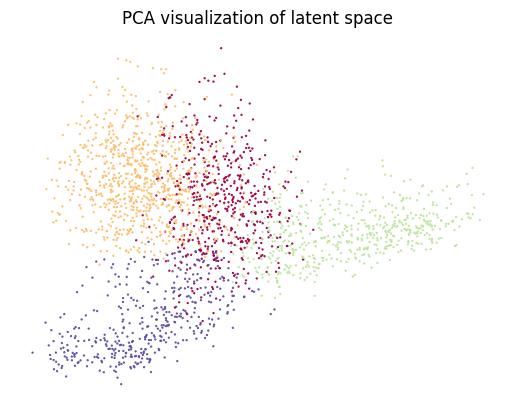

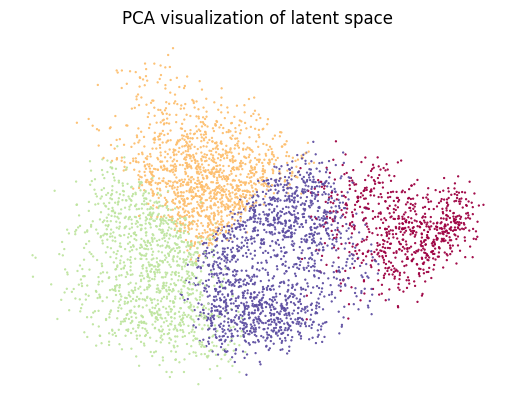

In [12]:
def vis_latent(latent_space, method,):
    if method == "PCA":
        reduced_latent = PCA(n_components=50).fit_transform(latent_space)
    elif method == "umap":
        reduced_latent = umap.UMAP(n_components=50).fit_transform(latent_space)
    elif method == "t-sne":
        reduced_latent = TSNE(n_components=2, random_state=42).fit_transform(latent_space)
    kmeans_labels = cluster.KMeans(n_clusters=4).fit_predict(latent_space)
    plt.scatter(reduced_latent[:, 0], 
                reduced_latent[:, 1], 
                c=kmeans_labels,
                s=0.4, cmap='Spectral')
    plt.title(f'{method} visualization of latent space')
    plt.axis("off")
    plt.show()
    return reduced_latent

# FFPE = all_data[all_data.obs["library_id"].isin(["FFPE"])]
# sc.pp.normalize_total(FFPE, inplace=True)
# sc.pp.log1p(FFPE)

data_FFPE = test_adata[test_adata.obs["library_id"]=="FFPE"]
latent_space = data_FFPE.obsm["resnet50_features"]
for method in ["PCA"]:
    reduced_latent_FFPE = vis_latent(latent_space, method)
    
data_1160920F = test_adata[test_adata.obs["library_id"]=="1160920F"]
latent_space = data_1160920F.obsm["resnet50_features"]
for method in ["PCA"]:
    reduced_latent_1160920F = vis_latent(latent_space, method)

#### Pathology Annotation - 1160920F

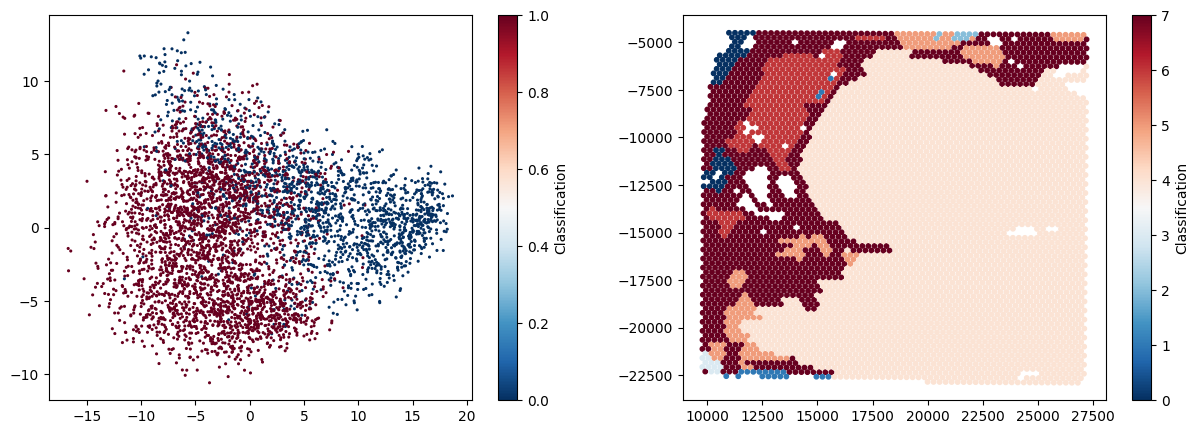

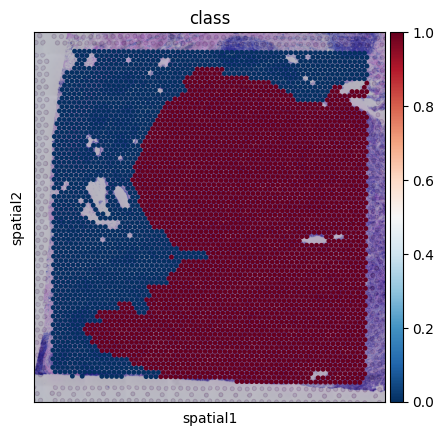

In [24]:
meta = pd.read_csv("/QRISdata/Q2051/STimage_project/STimage_dataset/RAW/Alex_NatGen_6BreastCancer/1160920F/metadata.csv", 
                   index_col=0)
meta.index = meta.index+"-1160920F"
data_1160920F.obs["Classification"] = meta["Classification"]
data_1160920F.obs["encoded_Classification"] = le.fit_transform(data_1160920F.obs["Classification"])
data_1160920F.obs["class"] = (data_1160920F.obs["Classification"] == 'Invasive cancer + stroma + lymphocytes').astype(int)

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,5))
scatter1 = ax1.scatter(reduced_latent_1160920F[:,0:1],reduced_latent_1160920F[:,1:2],c=data_1160920F.obs["class"],cmap="RdBu_r",s=1.5,)
colorbar = plt.colorbar(scatter1, ax=ax1)
colorbar.set_label('Classification')
scatter2 = ax2.scatter(data_1160920F.obs["imagecol"],-data_1160920F.obs["imagerow"],c=le.fit_transform(data_1160920F.obs["Classification"]),s=10, cmap="RdBu_r")
colorbar = plt.colorbar(scatter2, ax=ax2)
colorbar.set_label('Classification')

# sc.pl.spatial(data_1160920F, img_key="hires", color="Classification", size=1.5, library_id="1160920F", cmap="Set1_r")
# sc.pl.spatial(data_1160920F, img_key="hires", color="class", size=1.5, library_id="1160920F", cmap="RdBu_r")

#### Gene Expression plot on Latent Space

In [1]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (17.5,5))
# ax1.scatter(reduced_latent_FFPE[:,0:1],reduced_latent_FFPE[:,1:2],c=data_FFPE.obs["class"],cmap="RdBu_r",s=1.5)
ax1.scatter(reduced_latent_FFPE[:,0:1],reduced_latent_FFPE[:,1:2],c=FFPE.to_df().apply(normalize_column)["CD24"],cmap="RdBu_r",s=2.5)
ax2.scatter(reduced_latent_FFPE[:,0:1],reduced_latent_FFPE[:,1:2],c=data_FFPE.obsm["continuous_predicted_gene_expression"]["CD24"],cmap="RdBu_r",s=2.5)
plt.savefig('CD24_LS_UMAP_FFPE.png', format='png', dpi=300)
plt.show()

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (17.5,5))
# ax1.scatter(reduced_latent_1160920F[:,0:1],reduced_latent_1160920F[:,1:2],c=data_1160920F.obs["class"],cmap="RdBu_r",s=1.5)
ax1.scatter(reduced_latent_1160920F[:,0:1],reduced_latent_1160920F[:,1:2],c=F1160920.to_df().apply(normalize_column)["CD24"],cmap="RdBu_r",s=2.5)
ax2.scatter(reduced_latent_1160920F[:,0:1],reduced_latent_1160920F[:,1:2],c=data_1160920F.obsm["continuous_predicted_gene_expression"]["CD24"],cmap="RdBu_r",s=2.5)
plt.savefig('CD24_LS_UMAP_1160920F.png', format='png', dpi=300)
plt.show()